# Making Predictions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

from statsmodels.tsa.ar_model import AutoReg
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

##  Getting all the datasets

In [2]:
# importing the prediction data
df_pred = pd.read_csv('../clean_data/predictions.csv')

# lets rename columns for easy use
df_pred.rename(columns={"Unnamed: 0": "date" , "7dayrollingavg_newlyconfirmed":"7D_roll_pred", 'County':'county'},inplace = True)

# lets reset the index to county
df_pred.set_index('county', inplace= True)

# import data wise california vaccine allocation

df_vacc_alloc = pd.read_csv('../clean_data/vaccine_population.csv')
df_vacc_alloc = df_vacc_alloc[df_vacc_alloc['jurisdiction'] == 'California']
df_vacc_alloc.drop(columns=['2019_population','hhs_region','total_first_allocation' ], inplace = True)

# importing vaccination adminstration  data
df_vacc_admin = pd.read_csv('../clean_data/scrapped_ca_vaccine_ext_feb.csv')
df_vacc_admin.drop(columns=['Unnamed: 5','Unnamed: 6' , 'Unnamed: 4'], inplace = True)


# importing county population data
df_county_pop = pd.read_csv('../clean_data/cases_with_mask_use.csv')

# get county and population information only
df_county_pop = pd.DataFrame(df_county_pop.groupby(by = 'county')['population'].max())


##  EDA on county population

In [3]:
df_county_pop.head()

,population
county,
Alameda,1671329
Alpine,1129
Amador,39752
Butte,219186
Calaveras,45905


In [4]:
# Lets create a column that gives the county population ratio to California pop
# of county population to total california population. We will use this for dosage distribution
df_county_pop['ratio_county_pop'] = (df_county_pop['population']/ df_county_pop['population'].sum())
df_county_pop.reset_index(inplace= True)

## EDA on prediction data

In [5]:
# lets look at the data
df_pred.head()
# '2021-02-14'

,date,7D_roll_pred
county,,
Alameda,2020-09-27,5.572982
Alameda,2020-09-28,5.402031
Alameda,2020-09-29,5.419126
Alameda,2020-09-30,4.726777
Alameda,2020-10-01,4.367782


## EDA on vaccination Adminstration data

In [6]:
df_vacc_admin

,state,date,total_doses_distributed,total_doses_administered
0,California,2021-01-16,3548575,1072959
1,California,2021-01-17,3548575,1072959
2,California,2021-01-18,3548575,1072959
3,California,2021-01-19,3548575,1072959
4,California,2021-01-20,3548575,1072959
5,California,2021-01-21,4169450,1532329
6,California,2021-01-22,4379500,1633875
7,California,2021-01-23,4714625,1803679
8,California,2021-01-24,4906525,2008220
9,California,2021-01-25,4906525,2199908


In [7]:
# lets look at the data
df_vacc_admin = df_vacc_admin[df_vacc_admin['state']=='California'][['state' , 'date' ,'total_doses_distributed','total_doses_administered']]
df_vacc_admin["date"]= pd.to_datetime(df_vacc_admin["date"]) 

In [8]:
pd.set_option('display.max_rows', 100)
df_vacc_admin.head()

,state,date,total_doses_distributed,total_doses_administered
0,California,2021-01-16,3548575,1072959
1,California,2021-01-17,3548575,1072959
2,California,2021-01-18,3548575,1072959
3,California,2021-01-19,3548575,1072959
4,California,2021-01-20,3548575,1072959


#### Two steps to be added for this
#### Step 1: need to roll up the data for 7 day ahead. i.e 2021-01-16 should be summed up for 6 days ahead.
#### Step 2: need to split up the data for each county by date.



### Step 1: need to roll up the data for 7 day ahead. i.e 2021-01-16 should be summed up for 6 days ahead.

In [9]:
df_vacc_admin

,state,date,total_doses_distributed,total_doses_administered
0,California,2021-01-16,3548575,1072959
1,California,2021-01-17,3548575,1072959
2,California,2021-01-18,3548575,1072959
3,California,2021-01-19,3548575,1072959
4,California,2021-01-20,3548575,1072959
5,California,2021-01-21,4169450,1532329
6,California,2021-01-22,4379500,1633875
7,California,2021-01-23,4714625,1803679
8,California,2021-01-24,4906525,2008220
9,California,2021-01-25,4906525,2199908


In [10]:
# lets create new column that is the cumulative 7 days for doses adminstered and doses distributed

df_vacc_admin['doses_dist_7roll'] = 0
df_vacc_admin['doses_admin_7roll'] = 0
for i in range(0,30):
    df_vacc_admin['doses_dist_7roll'][i]= df_vacc_admin['total_doses_distributed'][i+6]- df_vacc_admin['total_doses_distributed'][i]
    df_vacc_admin['doses_admin_7roll'][i]= df_vacc_admin['total_doses_administered'][i+6]- df_vacc_admin['total_doses_administered'][i]
    

In [11]:
# lets remove the dates we dont need i.e any records beyond 2021-02-14
df_vacc_admin = df_vacc_admin[df_vacc_admin['date'] <= '2021-02-14']

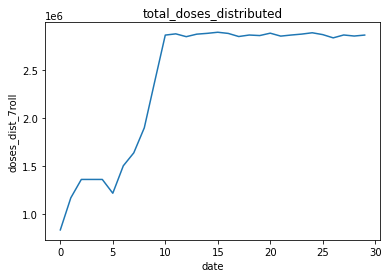

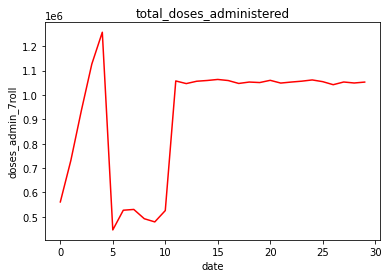

In [12]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(df_vacc_admin.index, df_vacc_admin['doses_dist_7roll'])
plt.title('total_doses_distributed')
plt.ylabel('doses_dist_7roll');
plt.xlabel('date');
plt.show()

# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(df_vacc_admin.index, df_vacc_admin['doses_admin_7roll'] , 'r')
plt.title('total_doses_administered')
plt.ylabel('doses_admin_7roll');
plt.xlabel('date');
plt.show()

### Step 2: Need to split the data by county

In [13]:
df_county_pop.head()

,county,population,ratio_county_pop
0,Alameda,1671329,0.042299
1,Alpine,1129,0.000029
2,Amador,39752,0.001006
3,Butte,219186,0.005547
4,Calaveras,45905,0.001162


In [14]:
df_vacc_admin.head()

,state,date,total_doses_distributed,total_doses_administered,doses_dist_7roll,doses_admin_7roll
0,California,2021-01-16,3548575,1072959,830925,560916
1,California,2021-01-17,3548575,1072959,1166050,730720
2,California,2021-01-18,3548575,1072959,1357950,935261
3,California,2021-01-19,3548575,1072959,1357950,1126949
4,California,2021-01-20,3548575,1072959,1357950,1257674


In [15]:
# lets do a cross join and merge the data sets for county and county population ratio. 
# this will help us to divide the doses admininstered and doses distributed 7 days cumulative by county

# since we have to do a cross join on two data frames that donot have a Key, lets create a key that is same.
df_county_pop['joinkey'] = 0
df_vacc_admin['joinkey'] = 0

# lets merge the vaccine and county population data together
df_county_vacc_dist_admin_7Droll = pd.merge(df_vacc_admin, df_county_pop, on="joinkey" , how="outer")

# selecting only the columns we need
df_county_vacc_dist_admin_7Droll = df_county_vacc_dist_admin_7Droll[['county' ,'date','doses_dist_7roll','doses_admin_7roll', 'ratio_county_pop']]

# rounding the county distribution and adminstration numbers
df_county_vacc_dist_admin_7Droll['doses_dist_7roll_county'] = round(df_county_vacc_dist_admin_7Droll['doses_dist_7roll'] * df_county_vacc_dist_admin_7Droll['ratio_county_pop'])
df_county_vacc_dist_admin_7Droll['doses_admin_7roll_county'] = round(df_county_vacc_dist_admin_7Droll['doses_admin_7roll'] * df_county_vacc_dist_admin_7Droll['ratio_county_pop'])

# selecting only the columns we needed
df_county_vacc_dist_admin_7Droll=df_county_vacc_dist_admin_7Droll[['county', 'date', 'doses_dist_7roll_county' , 'doses_admin_7roll_county' ]]

In [16]:
# final data set for Vaccine Adminstraion and Distribution by County and Date
df_county_vacc_dist_admin_7Droll

,county,date,doses_dist_7roll_county,doses_admin_7roll_county
0,Alameda,2021-01-16,35147.0,23726.0
1,Alpine,2021-01-16,24.0,16.0
2,Amador,2021-01-16,836.0,564.0
3,Butte,2021-01-16,4609.0,3112.0
4,Calaveras,2021-01-16,965.0,652.0
...,...,...,...,...
1735,Tulare,2021-02-14,33807.0,12424.0
1736,Tuolumne,2021-02-14,3951.0,1452.0
1737,Ventura,2021-02-14,61350.0,22546.0
1738,Yolo,2021-02-14,15990.0,5876.0


### Merge data sets together

#### create a dataframe that has County, Date, Prediction, County population, vaccine allocation

In [17]:
# lets add population to predictions 
df_county_vacc_pred_7Droll  =  pd.merge(df_pred ,df_county_pop, on ='county' , how = 'left' )

# since the 7 day rolling average was based off 100K , we need to calculate actual number of 7 day new patients

df_county_vacc_pred_7Droll['7D_roll_pred_tot'] = np.round((df_county_vacc_pred_7Droll['7D_roll_pred'] * df_county_vacc_pred_7Droll['population'])/ 100_000)

# lets look at merged data
df_county_vacc_pred_7Droll = df_county_vacc_pred_7Droll[['county', 'date' ,'7D_roll_pred_tot' ]]

### Append the 'county to population ratio' to merged data set.

In [18]:
df_county_vacc_pred_7Droll["date"]= pd.to_datetime(df_county_vacc_pred_7Droll["date"]) 

In [19]:
df_county_resource = pd.merge(df_county_vacc_pred_7Droll, df_county_vacc_dist_admin_7Droll, on=['county' , 'date'], how="inner")

In [20]:
df_county_resource

,county,date,7D_roll_pred_tot,doses_dist_7roll_county,doses_admin_7roll_county
0,Alameda,2021-01-16,923.0,35147.0,23726.0
1,Alameda,2021-01-17,895.0,49323.0,30909.0
2,Alameda,2021-01-18,856.0,57440.0,39561.0
3,Alameda,2021-01-19,827.0,57440.0,47669.0
4,Alameda,2021-01-20,745.0,57440.0,53198.0
...,...,...,...,...,...
1675,Yuba,2021-02-10,48.0,5714.0,2100.0
1676,Yuba,2021-02-11,48.0,5647.0,2075.0
1677,Yuba,2021-02-12,48.0,5707.0,2097.0
1678,Yuba,2021-02-13,48.0,5685.0,2089.0


### Calculate the DELTA the difference between predicted new patients and vaccines available

In [21]:
df_county_resource['delta'] = df_county_resource['7D_roll_pred_tot']*2 - ( df_county_resource['doses_dist_7roll_county']- df_county_resource['doses_admin_7roll_county'])

In [24]:
df_county_resource[df_county_resource['date'] == '2021-01-31']

,county,date,7D_roll_pred_tot,doses_dist_7roll_county,doses_admin_7roll_county,delta
15,Alameda,2021-01-31,411.0,122449.0,45000.0,-76627.0
45,Amador,2021-01-31,16.0,2912.0,1070.0,-1810.0
75,Butte,2021-01-31,68.0,16058.0,5901.0,-10021.0
105,Calaveras,2021-01-31,17.0,3363.0,1236.0,-2093.0
135,Colusa,2021-01-31,12.0,1579.0,580.0,-975.0
165,Contra Costa,2021-01-31,299.0,84512.0,31058.0,-52856.0
195,Del Norte,2021-01-31,2.0,2038.0,749.0,-1285.0
225,El Dorado,2021-01-31,92.0,14128.0,5192.0,-8752.0
255,Fresno,2021-01-31,280.0,73198.0,26900.0,-45738.0
285,Glenn,2021-01-31,5.0,2080.0,764.0,-1306.0


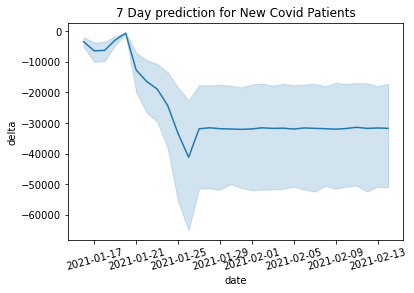

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.lineplot(x="date", y="delta", data=df_county_resource)
plt.xticks(rotation=15)
plt.title('7 Day prediction for New Covid Patients')
plt.show()